**Cohortes Avanzados**

In [ ]:
%run './EDA.ipynb'
%run './analisis-calidad-datos-y-outliers.ipynb'

**1. Estacionalidad:**
- Cohorte Mensual: Análisis mensual de volúmenes de compra por región para identificar patrones estacionales.
- Comparación Año a Año: Comparar volúmenes y precios promedio año a año para identificar temporadas de alta demanda.
- Días Festivos y Temporadas de Vacaciones: Crear cohortes basados en semanas festivas y periodos de vacaciones para analizar cambios en compras.

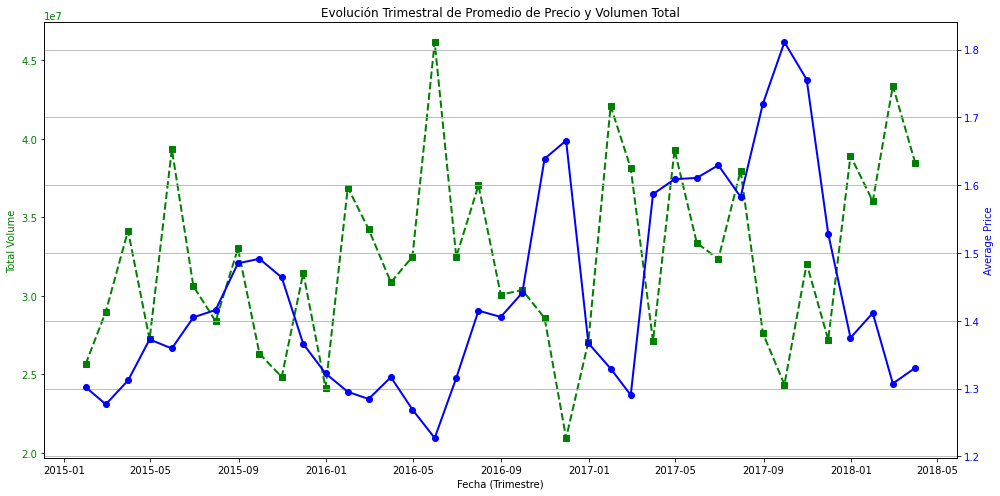

In [36]:
# Crear cohortes menual usando AveragePrice, Total Volume y Date.
cor1 = df_avocado_hotels.groupby(pd.Grouper(key='Date', freq='M')).agg(
    avg_price=('AveragePrice', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()

# Visualización
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de líneas para el volumen total
ax1.plot(cor1['Date'], cor1['total_volume'], marker='s', label='Total Volume', linestyle='--', linewidth=2, color='green')
ax1.set_xlabel('Fecha (Trimestre)')
ax1.set_ylabel('Total Volume', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Crear un segundo eje y para el promedio de precio
ax2 = ax1.twinx()
ax2.plot(cor1['Date'], cor1['avg_price'], marker='o', label='Average Price', linestyle='-', linewidth=2, color='blue')
ax2.set_ylabel('Average Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Evolución Trimestral de Promedio de Precio y Volumen Total')
fig.tight_layout()
plt.grid(True)
plt.show()

In [37]:
df_avocado_hotels

,Date,AveragePrice,Total Volume,4046,4225,4770,type,year,region,location,cant_toneladas,precio_tonelada
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,Albany,newyork,64.24,5319.720087
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,Albany,newyork,54.88,5399.702843
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,Albany,newyork,118.22,3720.006923
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,Albany,newyork,78.99,4320.117585
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,Albany,newyork,51.04,5119.959875
...,...,...,...,...,...,...,...,...,...,...,...,...
18112,2018-02-04,1.34,28070.07,13610.05,12257.81,0.00,organic,2018,SanFrancisco,california,28.07,4466.677805
18113,2018-01-28,2.27,20325.75,9368.06,8808.80,0.00,organic,2018,SanFrancisco,california,20.33,7565.084850
18114,2018-01-21,1.36,27919.45,13037.67,11998.44,0.00,organic,2018,SanFrancisco,california,27.92,4533.244031
18115,2018-01-14,1.32,37347.89,19301.15,14957.23,0.00,organic,2018,SanFrancisco,california,37.35,4399.751432


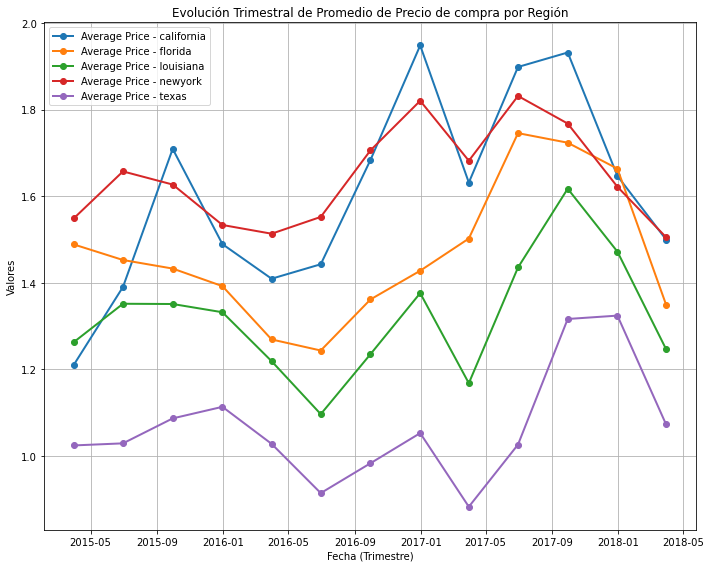

In [38]:

# Agrupar los datos por location y trimestre y calcular el promedio de 'AveragePrice' y la suma de 'Total Volume'
cor2 = df_avocado_hotels.groupby([pd.Grouper(key='Date', freq='Q'), 'location']).agg(
    avg_price=('AveragePrice', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()

# Visualización de la evolución de las cohortes por región
plt.figure(figsize=(10, 8))

# Gráfico de líneas para comparar las regiones
for region in cor2['location'].unique():
    region_data = cor2[cor2['location'] == region]
    plt.plot(region_data['Date'], region_data['avg_price'], marker='o', label=f'Average Price - {region}', linewidth=2)

plt.title('Evolución Trimestral de Promedio de Precio de compra por Región')
plt.xlabel('Fecha (Trimestre)')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

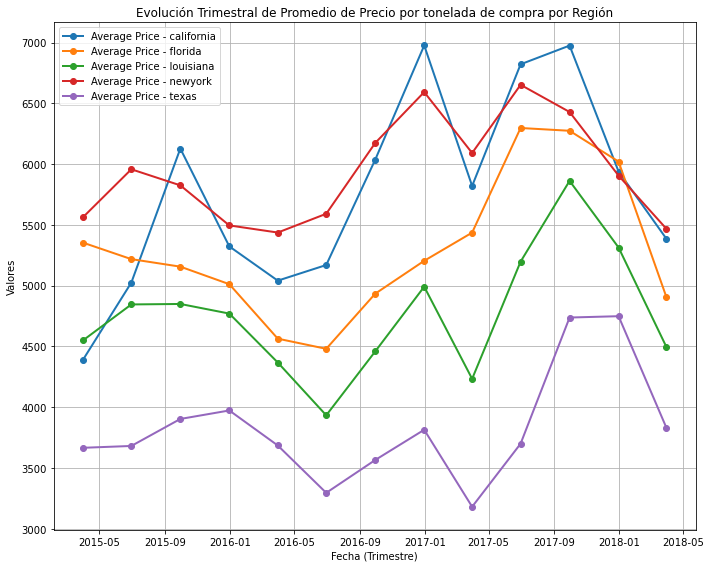

In [42]:
# Agrupar los datos por location y trimestre y calcular el promedio de 'AveragePrice' y la suma de 'Total Volume'
cor2 = df_avocado_hotels.groupby([pd.Grouper(key='Date', freq='Q'), 'location']).agg(
    avg_price=('precio_tonelada', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()

# Visualización de la evolución de las cohortes por región
plt.figure(figsize=(10, 8))

# Gráfico de líneas para comparar las regiones
for region in cor2['location'].unique():
    region_data = cor2[cor2['location'] == region]
    plt.plot(region_data['Date'], region_data['avg_price'], marker='o', label=f'Average Price - {region}', linewidth=2)

plt.title('Evolución Trimestral de Promedio de Precio por tonelada de compra por Región')
plt.xlabel('Fecha (Trimestre)')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**2. Exceso de Compras (Desperdicios o Fechas Especiales):**
- Compras Atípicas: Detectar semanas con volúmenes significativamente superiores a la media para investigar posibles desperdicios.
- Eventos Especiales: Identificar picos de compras asociados con eventos conocidos o temporadas de promociones de hoteles.
- Cohorte de Variabilidad de Precios: Analizar semanas con cambios bruscos en precios para correlacionarlos con posibles excesos de compra.

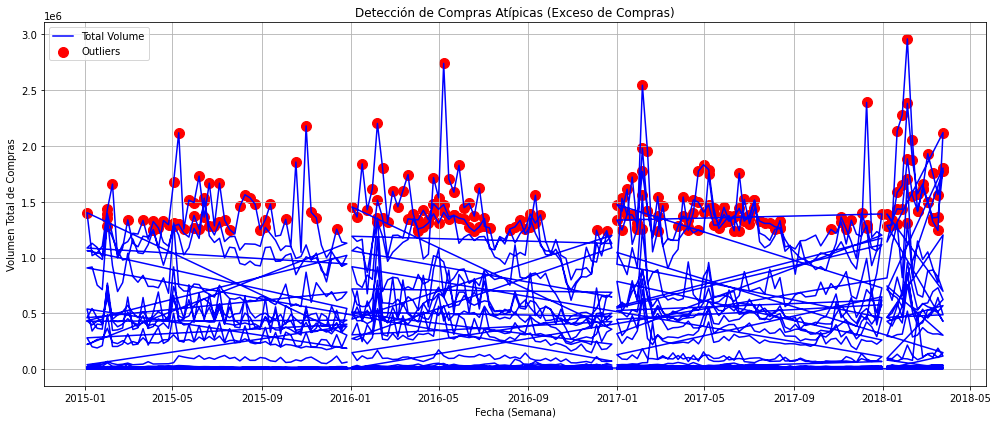

,Date,AveragePrice,Total Volume,4046,4225,4770,type,year,region,location,cant_toneladas,precio_tonelada
588,2015-09-06,0.84,1270739.69,626166.71,505568.94,9815.66,conventional,2015,DallasFtWorth,texas,1270.74,3359.999180
597,2015-07-05,0.83,1320696.13,835215.79,334916.29,5388.47,conventional,2015,DallasFtWorth,texas,1320.70,3319.990272
599,2015-06-21,0.75,1283503.44,755351.26,375820.52,8600.70,conventional,2015,DallasFtWorth,texas,1283.50,3000.008041
600,2015-06-14,0.65,1508750.45,1013252.58,353165.21,7557.93,conventional,2015,DallasFtWorth,texas,1508.75,2600.000775
601,2015-06-07,0.73,1255575.78,788982.74,319283.75,13350.40,conventional,2015,DallasFtWorth,texas,1255.58,2919.990186
...,...,...,...,...,...,...,...,...,...,...,...,...
8823,2018-01-21,1.27,2135242.76,46444.43,1642533.16,1165.10,conventional,2018,NewYork,newyork,2135.24,5080.006566
8824,2018-01-14,1.67,1294149.71,39681.84,818051.50,1338.06,conventional,2018,NewYork,newyork,1294.15,6679.998503
8825,2018-01-07,1.67,1287480.31,39884.07,866953.05,573.69,conventional,2018,NewYork,newyork,1287.48,6680.001608
8989,2018-02-04,0.84,1706251.05,459981.14,1113987.54,2886.78,conventional,2018,SanFrancisco,california,1706.25,3360.002068


In [43]:
# Calcular estadísticas para detección de compras atípicas
volume_mean = df_avocado_hotels['Total Volume'].mean()
volume_std = df_avocado_hotels['Total Volume'].std()

# Identificar semanas con volúmenes superiores a la media + 2 desviaciones estándar
df_outliers = df_avocado_hotels[df_avocado_hotels['Total Volume'] > (volume_mean + 2 * volume_std)]

# Visualizar semanas atípicas
plt.figure(figsize=(14, 6))

# Gráfico de líneas de compras totales
plt.plot(df_avocado_hotels['Date'], df_avocado_hotels['Total Volume'], label='Total Volume', color='blue')
plt.scatter(df_outliers['Date'], df_outliers['Total Volume'], color='red', s=100, label='Outliers')

plt.title('Detección de Compras Atípicas (Exceso de Compras)')
plt.xlabel('Fecha (Semana)')
plt.ylabel('Volumen Total de Compras')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar registros atípicos detectados
df_outliers


In [44]:
# Ordenar el DataFrame por 'Total Volume' en orden descendente y seleccionar los 10 más altos
top_10_peaks = df_avocado_hotels.nlargest(10, 'Total Volume')[['Date', 'Total Volume', 'location','cant_toneladas']]
# Redondear 'Total Volume' a 2 decimales
top_10_peaks['Total Volume'] = top_10_peaks['Total Volume'].round(2)

# Mostrar la tabla de los 10 picos más altos
top_10_peaks

,Date,Total Volume,location,cant_toneladas
8821,2018-02-04,2959541.38,newyork,2959.54
4297,2016-05-08,2740587.86,newyork,2740.59
7147,2017-02-05,2544483.08,newyork,2544.48
7103,2017-12-10,2390308.58,newyork,2390.31
8701,2018-02-04,2381742.59,texas,2381.74
8822,2018-01-28,2278728.69,newyork,2278.73
4310,2016-02-07,2202127.86,newyork,2202.13
1464,2015-11-01,2180520.22,newyork,2180.52
8823,2018-01-21,2135242.76,newyork,2135.24
8694,2018-03-25,2120511.03,texas,2120.51


**3. Tipos de Aguacates (Orgánico vs. Convencional):**
- Segmentación por Tipo de Aguacate: Crear cohortes de compras separadas por type (orgánico vs. convencional) y analizar diferencias en precios y volúmenes por temporada.
- Demanda Relativa: Comparar la proporción de compras de orgánico vs. convencional a lo largo del año.

**4. Proveedores y Seguridad de Consumo:**
- Ranking de Proveedores: Crear un ranking de regiones/productores según precios promedio y estabilidad de oferta a lo largo del año.
- Análisis de Vacíos de Oferta: Identificar periodos de baja oferta de ciertos productores y buscar productores alternativos con precios competitivos en esas fechas.